# Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import joblib
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import   precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

In [5]:
df = pd.read_csv('intent_classification_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"Intent distribution:\n{df.intent.value_counts()}")

Dataset shape: (1000, 2)
Intent distribution:
intent
web_search           200
knowledge_query      200
general_chat         200
email_send           200
calendar_schedule    200
Name: count, dtype: int64


In [6]:
# Text preprocessing
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    return ' '.join(text.split())

df['cleaned_text'] = df['text'].apply(clean_text)

In [7]:
nlp = spacy.load("en_core_web_sm")

# Tokenize and lemmatize
def process_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc 
              if not token.is_stop and not token.is_punct and len(token.text) > 1]
    return ' '.join(tokens)

df['processed_text'] = df['cleaned_text'].apply(process_text)

In [8]:
df

,text,intent,cleaned_text,processed_text
0,What are the reviews for the new iPhone?,web_search,what are the reviews for the new iphone,review new iphone
1,What are the expectations for employee conduct...,knowledge_query,what are the expectations for employee conduct...,expectation employee conduct company sponsor e...
2,What are the company's core values and mission...,knowledge_query,what are the company s core values and mission...,company core value mission statement
3,What is the process for providing feedback or ...,knowledge_query,what is the process for providing feedback or ...,process provide feedback suggestion company po...
4,Look up the history of the Eiffel Tower,web_search,look up the history of the eiffel tower,look history eiffel tower
...,...,...,...,...
995,Can you email the meeting minutes to the board...,email_send,can you email the meeting minutes to the board...,email meeting minute board director
996,I need to book a meeting with the research tea...,calendar_schedule,i need to book a meeting with the research tea...,need book meeting research team discuss recent...
997,How was your experience at the concert last ni...,general_chat,how was your experience at the concert last night,experience concert night
998,What are the business hours for the local libr...,web_search,what are the business hours for the local library,business hour local library


# Feature Engineering

In [9]:
# Create TF-IDF features
tfidf = TfidfVectorizer(max_features = 1000, ngram_range=(1, 2))
tfidf_features = tfidf.fit_transform(df['processed_text'])
print(f"TF-IDF shape: {tfidf_features.shape}")

TF-IDF shape: (1000, 1000)


In [10]:
# Create keyword features
keywords = ["email", "schedule", "find", "what", "how"]
keyword_features = np.zeros((len(df), len(keywords)))

for i, text in enumerate(df['text']):
    text_lower = str(text).lower()
    for j, keyword in enumerate(keywords):
        keyword_features[i, j] = 1 if keyword in text_lower else 0

print(f"Keyword features shape: {keyword_features.shape}")

Keyword features shape: (1000, 5)


In [11]:
# Combine features
X = hstack([tfidf_features, csr_matrix(keyword_features)])
print(f"Combined features shape: {X.shape}")

Combined features shape: (1000, 1005)


In [12]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['intent'])
print(f"Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

Label mapping: {'calendar_schedule': 0, 'email_send': 1, 'general_chat': 2, 'knowledge_query': 3, 'web_search': 4}


In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}, Val: {X_test.shape}")

# Store original texts for later analysis (placeholder version)
test_indices = []
X_test_texts = []

for i in range(X_test.shape[0]): 
    X_test_texts.append(f"Test sample {i}")

Train: (800, 1005), Val: (200, 1005)


# Model training with cross-validation

In [14]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Naive Bayes

In [15]:
# Define model and hyperparameter grid
nb_model = MultinomialNB()
nb_param_grid = {
    'alpha': [0.1, 1.0, 10.0]
}

# Grid search
nb_grid = GridSearchCV(
    estimator=nb_model,
    param_grid=nb_param_grid,
    cv=cv,
    scoring='accuracy',
    refit=True,
    n_jobs=-1
)
nb_grid.fit(X_train, y_train)

# Best estimator & predict
best_nb = nb_grid.best_estimator_

# Logistic Regression

In [16]:
lr_model = LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000
)
lr_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0]
}

# Grid search
lr_grid = GridSearchCV(
    estimator=lr_model,
    param_grid=lr_param_grid,
    cv=cv,
    scoring='accuracy',
    refit=True,
    n_jobs=-1
)
lr_grid.fit(X_train, y_train)

# Best estimator & predict
best_lr = lr_grid.best_estimator_

c:\Users\ummed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# RandomForest

In [17]:
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid search
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=cv,
    scoring='accuracy',
    refit=True,
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

# Best estimator
best_rf = rf_grid.best_estimator_
print(f"Best RF parameters: {rf_grid.best_params_}")

Best RF parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


# Ensemble Model

In [18]:
ensemble_model = VotingClassifier(
    estimators=[
        ('nb', best_nb),
        ('lr', best_lr),
        ('rf', best_rf)  # Added Random Forest
    ],
    voting='soft'  # Soft voting for probability predictions
)

# Train the ensemble model
print("\nTraining ensemble model...")
ensemble_model.fit(X_train, y_train)


Training ensemble model...


c:\Users\ummed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,estimators,"[('nb', ...), ('lr', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,alpha,0.1
,force_alpha,True
,fit_prior,True
,class_prior,None
,penalty,'l2'


# Evaluate Models

In [19]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_pred_nb = best_nb.predict(X_test)
print("Naive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Performance:
Accuracy: 0.9950
F1 Score: 0.9950
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       0.98      1.00      0.99        40
           3       1.00      1.00      1.00        40
           4       1.00      0.97      0.99        40

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [20]:
y_pred_lr = best_lr.predict(X_test)
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
Accuracy: 0.9900
F1 Score: 0.9900
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       0.95      1.00      0.98        40
           3       1.00      1.00      1.00        40
           4       1.00      0.95      0.97        40

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



In [21]:
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)

print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

Random Forest Performance:
Accuracy: 0.9750
F1 Score: 0.9752
Classification Report:
                   precision    recall  f1-score   support

calendar_schedule       1.00      1.00      1.00        40
       email_send       1.00      1.00      1.00        40
     general_chat       0.91      0.97      0.94        40
  knowledge_query       1.00      0.95      0.97        40
       web_search       0.97      0.95      0.96        40

         accuracy                           0.97       200
        macro avg       0.98      0.97      0.98       200
     weighted avg       0.98      0.97      0.98       200



In [22]:
y_pred_ensemble = ensemble_model.predict(X_test)
y_proba_ensemble = ensemble_model.predict_proba(X_test)

print("Enhanced Ensemble Model Performance (NB + LR + RF):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_ensemble, average='weighted'):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_ensemble, target_names=label_encoder.classes_))

Enhanced Ensemble Model Performance (NB + LR + RF):
Accuracy: 0.9950
F1 Score: 0.9950
Classification Report:
                   precision    recall  f1-score   support

calendar_schedule       1.00      1.00      1.00        40
       email_send       1.00      1.00      1.00        40
     general_chat       0.98      1.00      0.99        40
  knowledge_query       1.00      1.00      1.00        40
       web_search       1.00      0.97      0.99        40

         accuracy                           0.99       200
        macro avg       1.00      0.99      0.99       200
     weighted avg       1.00      0.99      0.99       200



# Function to Test on Unseen Data

In [23]:
def predict_intent_with_confidence(text, model, vectorizer, label_enc, keyword_list):
    """
    Predict intent for unseen text with confidence score
    """
    # Preprocess text
    cleaned = clean_text(text)
    processed = process_text(cleaned)
    
    # Create TF-IDF features
    tfidf_feat = vectorizer.transform([processed])
    
    # Create keyword features
    keyword_feat = np.zeros((1, len(keyword_list)))
    text_lower = text.lower()
    for j, keyword in enumerate(keyword_list):
        keyword_feat[0, j] = 1 if keyword in text_lower else 0
    
    # Combine features
    combined_feat = hstack([tfidf_feat, csr_matrix(keyword_feat)])
    
    # Make prediction
    prediction = model.predict(combined_feat)[0]
    
    # Get confidence score
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(combined_feat)[0]
        confidence = max(probabilities)
        all_probs = dict(zip(label_enc.classes_, probabilities))
    else:
        # For SVM, use decision function
        scores = model.decision_function(combined_feat)[0]
        confidence = max(scores) if len(scores) > 1 else scores[0]
        all_probs = dict(zip(label_enc.classes_, scores))
    
    predicted_intent = label_enc.inverse_transform([prediction])[0]
    
    return {
        'text': text,
        'predicted_intent': predicted_intent,
        'confidence': confidence,
        'all_probabilities': all_probs
    }

In [24]:
# Test on some unseen examples
test_texts = [
    "Can you help me schedule a meeting for tomorrow?",
    "What's the weather like today?",
    "Send an email to my manager",
    "Find restaurants near me",
    "How do I reset my password?"
]

print("Testing on Unseen Data:")
print("=" * 50)

for text in test_texts:
    result = predict_intent_with_confidence(text, ensemble_model, tfidf, label_encoder, keywords)
    print(f"Text: {result['text']}")
    print(f"Predicted Intent: {result['predicted_intent']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Top 3 probabilities:")
    sorted_probs = sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True)
    for intent, prob in sorted_probs[:3]:
        print(f"  {intent}: {prob:.4f}")
    print("-" * 50)

Testing on Unseen Data:
Text: Can you help me schedule a meeting for tomorrow?
Predicted Intent: calendar_schedule
Confidence: 0.9614
Top 3 probabilities:
  calendar_schedule: 0.9614
  email_send: 0.0217
  web_search: 0.0127
--------------------------------------------------
Text: What's the weather like today?
Predicted Intent: general_chat
Confidence: 0.7017
Top 3 probabilities:
  general_chat: 0.7017
  web_search: 0.2835
  knowledge_query: 0.0122
--------------------------------------------------
Text: Send an email to my manager
Predicted Intent: email_send
Confidence: 0.9996
Top 3 probabilities:
  email_send: 0.9996
  web_search: 0.0001
  general_chat: 0.0001
--------------------------------------------------
Text: Find restaurants near me
Predicted Intent: web_search
Confidence: 0.9835
Top 3 probabilities:
  web_search: 0.9835
  knowledge_query: 0.0084
  general_chat: 0.0072
--------------------------------------------------
Text: How do I reset my password?
Predicted Intent: gen

# Comparsion of all the Models

In [25]:
model_scores = {
    "Naive Bayes": {
        "accuracy": accuracy_score(y_test, y_pred_nb),
        "f1_score":  f1_score(y_test, y_pred_nb, average='weighted')
    },
    "Logistic Regression": {
        "accuracy": accuracy_score(y_test, y_pred_lr),
        "f1_score":  f1_score(y_test, y_pred_lr, average='weighted')
    },
    "Random Forest": {
        "accuracy": accuracy_score(y_test, y_pred_rf),
        "f1_score":  f1_score(y_test, y_pred_rf, average='weighted')
    },
    "Ensemble": {
        "accuracy": accuracy_score(y_test, y_pred_ensemble),
        "f1_score":  f1_score(y_test, y_pred_ensemble, average='weighted')
    }
}

In [26]:
print("\nModel Performance Comparison:")
print(f"{'Model':<20} {'Accuracy':<10} {'F1 Score':<10}")
print("-" * 45)
for model, scores in model_scores.items():
    print(f"{model:<20} {scores['accuracy']:.4f}     {scores['f1_score']:.4f}")


Model Performance Comparison:
Model                Accuracy   F1 Score  
---------------------------------------------
Naive Bayes          0.9950     0.9950
Logistic Regression  0.9900     0.9900
Random Forest        0.9750     0.9752
Ensemble             0.9950     0.9950


# Save the Best Model

In [27]:
best_model = ensemble_model
y_pred_best = best_model.predict(X_test)

joblib.dump(best_model, 'intent_classifier.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

print("\nModel training completed and saved!")


Model training completed and saved!


# Visualization and Error Analysis

### Confusion Matrix

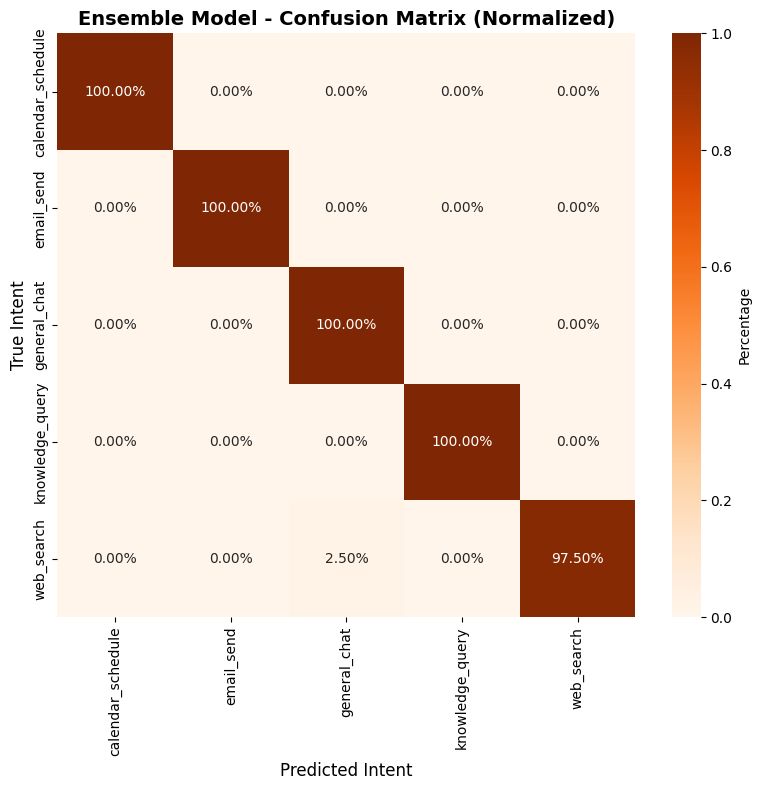

In [28]:
model_name = "Ensemble Model"
labels = label_encoder.classes_

# Compute normalized confusion matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Oranges',
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Percentage'})
plt.title(f'{model_name} - Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Intent', fontsize=12)
plt.ylabel('True Intent', fontsize=12)

plt.tight_layout()
plt.show()

## Bar Chart: Precision, Recall, F1 per class

<Figure size 1000x600 with 0 Axes>

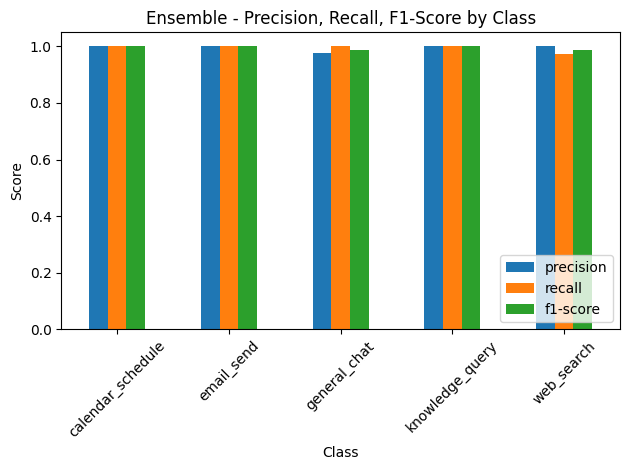

In [29]:
# Get classification report as dictionary for Ensemble model
report_ensemble = classification_report(y_test, y_pred_ensemble, target_names=label_encoder.classes_, output_dict=True)

# Prepare metrics data
classes = label_encoder.classes_
metrics_data_ensemble = {
    'precision': [report_ensemble[cls]['precision'] for cls in classes],
    'recall': [report_ensemble[cls]['recall'] for cls in classes],
    'f1-score': [report_ensemble[cls]['f1-score'] for cls in classes]
}

df_ensemble_metrics = pd.DataFrame(metrics_data_ensemble, index=classes)

# Plot
plt.figure(figsize=(10, 6))
df_ensemble_metrics.plot(kind='bar')
plt.title("Ensemble - Precision, Recall, F1-Score by Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ROC CURVES FOR MULTICLASS

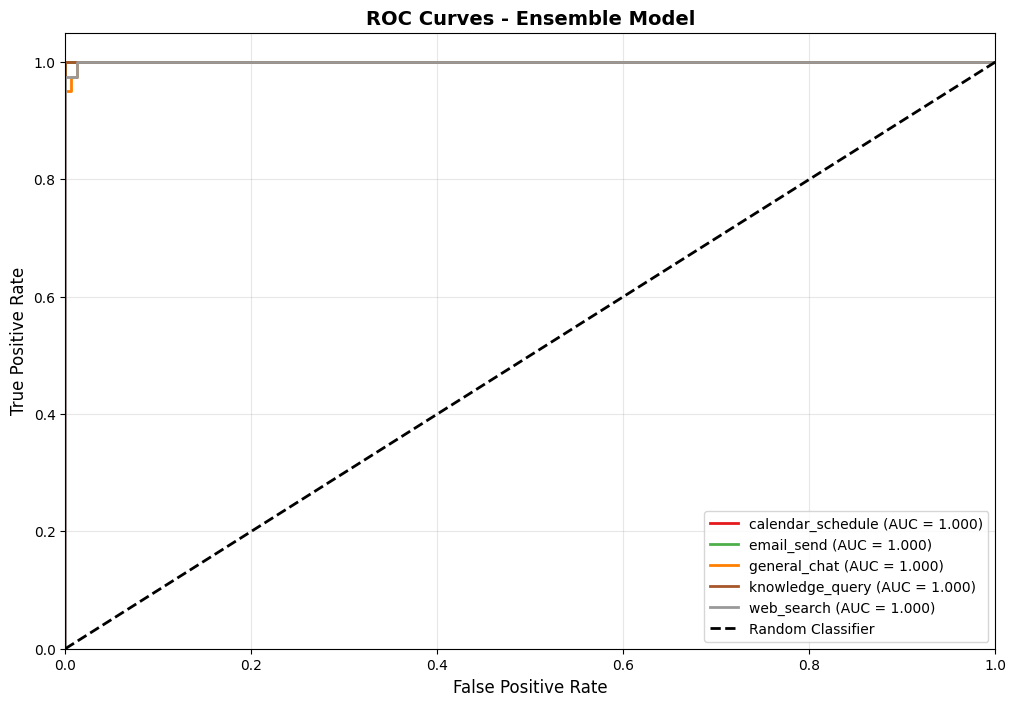

In [30]:
# Set model name and class labels
model_name = "Ensemble Model"
labels = label_encoder.classes_
n_classes = len(labels)

# Binarize the true labels
y_binary = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curves and AUC scores for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_proba_ensemble[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(12, 8))
colors = plt.cm.Set1(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{labels[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curves - {model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# Learning Curve

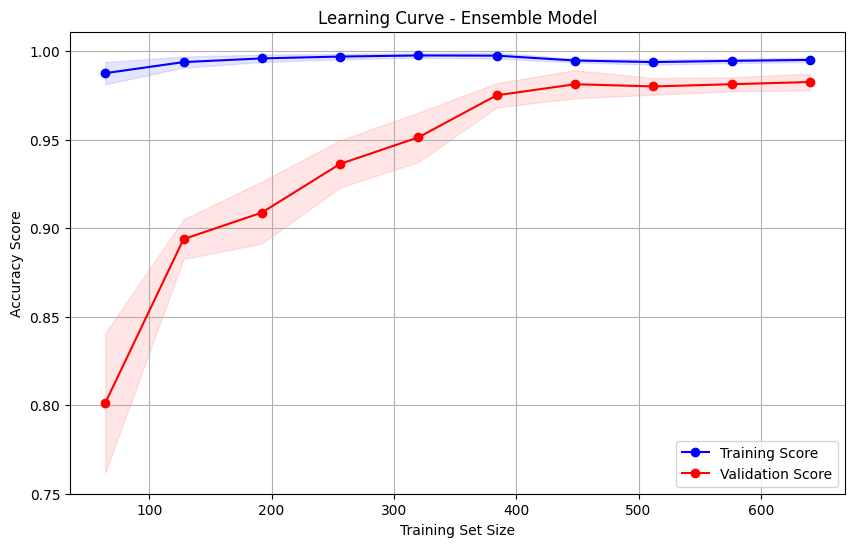

In [31]:
# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    ensemble_model, X_train, y_train,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calculate means and standard deviations
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
plt.title("Learning Curve - Ensemble Model")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid(True)
plt.show()

# Confidence Score Analysis

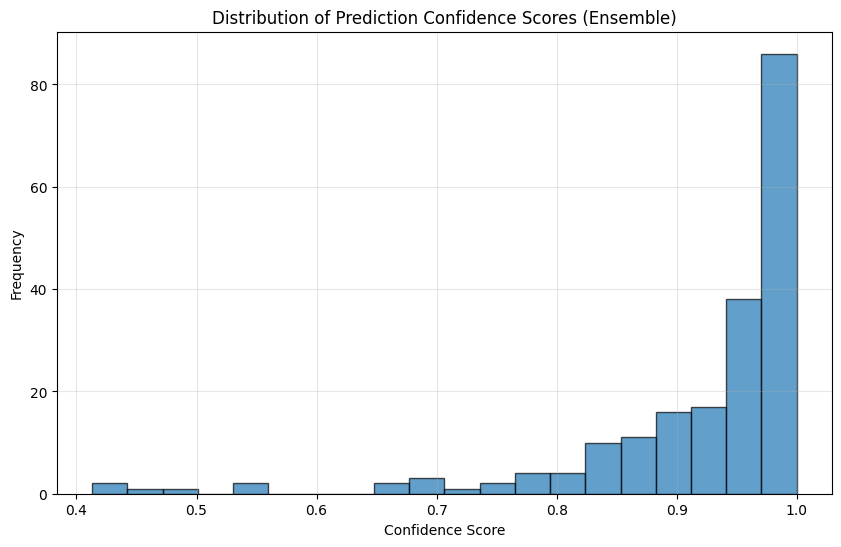

In [32]:
# Get confidence scores for ensemble predictions
confidences_ensemble = np.max(y_proba_ensemble, axis=1)

# Plot histogram of confidence scores
plt.figure(figsize=(10, 6))
plt.hist(confidences_ensemble, bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Prediction Confidence Scores (Ensemble)")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

# F1 Score vs Confidence Threshold

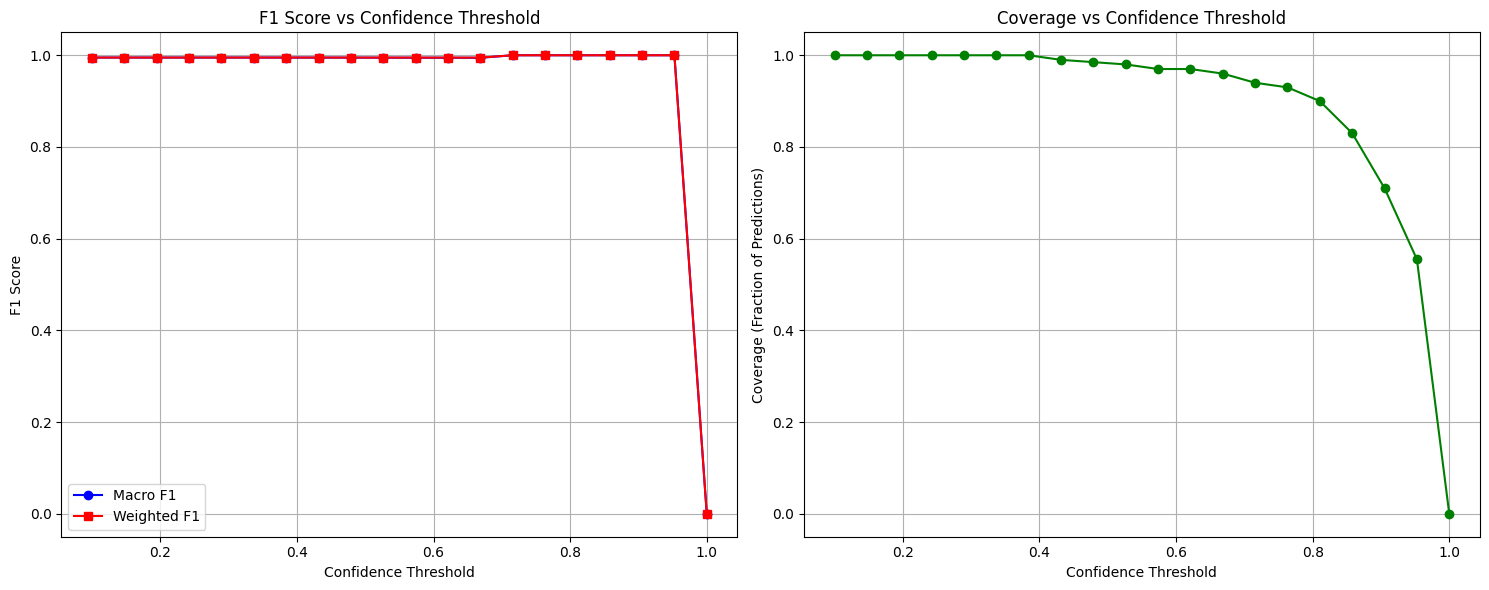

In [33]:
# Analyze F1 score at different confidence thresholds
thresholds = np.linspace(0.1, 1.0, 20)
macro_f1_scores = []
weighted_f1_scores = []
coverage = []

for threshold in thresholds:
    # Get predictions above threshold
    confident_mask = confidences_ensemble >= threshold
    
    if confident_mask.sum() == 0:
        macro_f1_scores.append(0)
        weighted_f1_scores.append(0)
        coverage.append(0)
        continue
    
    y_true_confident = y_test[confident_mask]
    y_pred_confident = y_pred_ensemble[confident_mask]
    
    # Calculate F1 scores
    macro_f1 = f1_score(y_true_confident, y_pred_confident, average='macro')
    weighted_f1 = f1_score(y_true_confident, y_pred_confident, average='weighted')
    
    macro_f1_scores.append(macro_f1)
    weighted_f1_scores.append(weighted_f1)
    coverage.append(confident_mask.mean())

# Plot F1 vs threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(thresholds, macro_f1_scores, 'o-', label='Macro F1', color='blue')
ax1.plot(thresholds, weighted_f1_scores, 's-', label='Weighted F1', color='red')
ax1.set_title("F1 Score vs Confidence Threshold")
ax1.set_xlabel("Confidence Threshold")
ax1.set_ylabel("F1 Score")
ax1.legend()
ax1.grid(True)

ax2.plot(thresholds, coverage, 'o-', color='green')
ax2.set_title("Coverage vs Confidence Threshold")
ax2.set_xlabel("Confidence Threshold")
ax2.set_ylabel("Coverage (Fraction of Predictions)")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Error Analysis

In [34]:
y_true = y_test
y_pred = y_pred_ensemble
confidences = np.max(y_proba_ensemble, axis=1)
labels = label_encoder.classes_

misclassified = y_true != y_pred

#  Error Rate by True Class

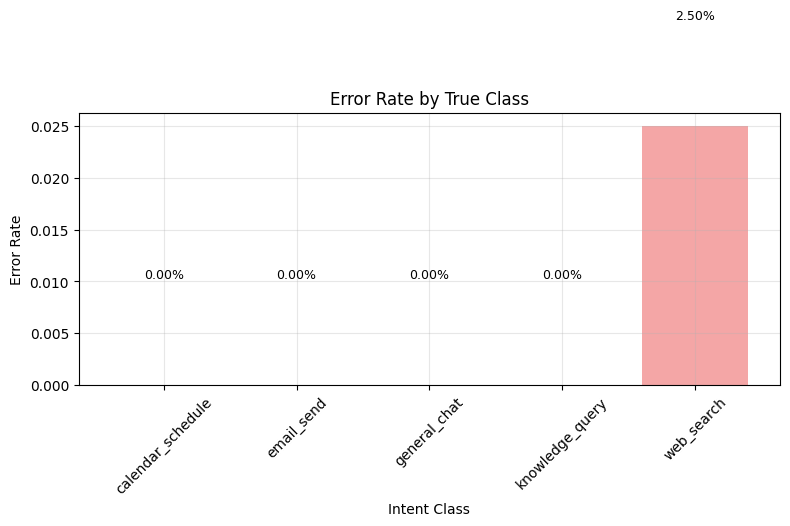

In [35]:
error_by_class = []
class_sizes = []

for i, label in enumerate(labels):
    mask = y_true == i
    if mask.sum() > 0:
        error_rate = misclassified[mask].mean()
        error_by_class.append(error_rate)
        class_sizes.append(mask.sum())
    else:
        error_by_class.append(0)
        class_sizes.append(0)

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, error_by_class, color='lightcoral', alpha=0.7)
plt.title('Error Rate by True Class')
plt.xlabel('Intent Class')
plt.ylabel('Error Rate')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Annotate bars
for bar, rate in zip(bars, error_by_class):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{rate:.2%}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Misclassified Examples

In [36]:
misclassified_indices = np.where(y_test != y_pred_ensemble)[0]
misclassified_confidences = confidences_ensemble[misclassified_indices]

print(f"Number of misclassified examples: {len(misclassified_indices)}")
print(f"Average confidence of misclassified examples: {misclassified_confidences.mean():.4f}")
print(f"Average confidence of correct predictions: {confidences_ensemble[y_test == y_pred_ensemble].mean():.4f}")

# Show most confident wrong predictions
if len(misclassified_indices) > 0:
    most_confident_wrong = misclassified_indices[np.argsort(misclassified_confidences)[-5:]]
    
    print("\nMost confident wrong predictions:")
    for idx in most_confident_wrong:
        true_label = label_encoder.inverse_transform([y_test[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_pred_ensemble[idx]])[0]
        confidence = confidences_ensemble[idx]
        print(f"True: {true_label}, Predicted: {pred_label}, Confidence: {confidence:.4f}")

Number of misclassified examples: 1
Average confidence of misclassified examples: 0.7075
Average confidence of correct predictions: 0.9213

Most confident wrong predictions:
True: web_search, Predicted: general_chat, Confidence: 0.7075


# Model Performance Summary

In [37]:
print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Best Model: Ensemble (Naive Bayes + Logistic Regression + RandomForestClassifer)")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}")
print(f"Test F1-Score (Weighted): {f1_score(y_test, y_pred_ensemble, average='weighted'):.4f}")
print(f"Test F1-Score (Macro): {f1_score(y_test, y_pred_ensemble, average='macro'):.4f}")
print(f"Average Confidence: {confidences_ensemble.mean():.4f}")
print(f"Total Test Samples: {len(y_test)}")
print("="*60)


FINAL MODEL PERFORMANCE SUMMARY
Best Model: Ensemble (Naive Bayes + Logistic Regression + RandomForestClassifer)
Test Accuracy: 0.9950
Test F1-Score (Weighted): 0.9950
Test F1-Score (Macro): 0.9950
Average Confidence: 0.9202
Total Test Samples: 200
